In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# import custom functions
from corrmat_functions import *

# Get tickers and filenames and clean them
files and tickers in order of file size (proxy for number of data points).

In [2]:
# get file names
cwd = os.getcwd() # get current working directory
file_folder = f'{cwd}/data/USD/' # speficy the folder containing original network files
file_list = os.listdir(file_folder)
file_list = sorted(file_list,
                        key =  lambda x: -os.stat(file_folder + x).st_size) # sort in descending order by file size

# extract token names from files names
tickers = []
for name in file_list:
    m = re.search('-([A-Z]*)_price', name)
    if m == None:
        continue
    tickers.append(m.group(1))

print(f"number of tickers and files before removing: {len(tickers)}, {len(file_list)}")

# remove stablecoins found in the data (manually append tickers of stablecoins)
stable_coins = ["PAX"]
print(f"number of stable coins to remove: {len(stable_coins)}")
for sc in stable_coins:
    for f in file_list:
        if sc in f:
            file_list.remove(f)
            tickers.remove(sc)

print(f"number of tickers and files after removing: {len(tickers)}, {len(file_list)}")

number of tickers and files before removing: 58, 58
number of stable coins to remove: 1
number of tickers and files after removing: 57, 57


# Load data
First check which files have an error message

In [3]:
# collect tickers of files with an error message instead of a header
file_names_with_error_message = []
headers = []
for file_name in file_list:
    with open(file_folder + file_name) as f:
        if f.read()[0] == "{":
            file_names_with_error_message.append(file_name)
            print(file_name)

USD-FX_price_hist_2020-01-01_2021-11-24.csv
USD-BAND_price_hist_2020-01-01_2021-11-25.csv
USD-MATIC_price_hist_2020-01-01_2021-11-25.csv
USD-FET_price_hist_2020-01-01_2021-11-25.csv
USD-DOT_price_hist_2020-01-01_2021-11-25.csv
USD-UNI_price_hist_2020-01-01_2021-11-25.csv
USD-REN_price_hist_2020-01-01_2021-11-25.csv
USD-NMR_price_hist_2020-01-01_2021-11-25.csv
USD-AVAX_price_hist_2020-01-01_2021-11-25.csv
USD-SOL_price_hist_2020-01-01_2021-11-25.csv
USD-XYO_price_hist_2020-01-01_2021-11-25.csv
USD-ANKR_price_hist_2020-01-01_2021-11-25.csv
USD-COTI_price_hist_2020-01-01_2021-11-25.csv
USD-NKN_price_hist_2020-01-01_2021-11-25.csv
USD-QNT_price_hist_2020-01-01_2021-11-25.csv
USD-IOTX_price_hist_2020-01-01_2021-11-24.csv
USD-MIR_price_hist_2020-01-01_2021-11-25.csv
USD-TRB_price_hist_2020-01-01_2021-11-25.csv
USD-GTC_price_hist_2020-01-01_2021-11-25.csv


Now we load the data into a dictionary with the tickers as keys.

In [4]:
raw_data = {}
# header = ["time","exchange","fsym","tsym","close","high","low","open","volumefrom","volumeto"]
cols = [0,4]  # only load columns 0 (time) and 4 (close)
header = ["time", "close"]  # header names to assign to the columns
nans = [f"nan.{i}" for i in np.arange(10)]  # parse missing values of the form NaN.# as np.nan

# read data
for i, file_name in enumerate(file_list):
    print(tickers[i])
    # raw_data[tickers[i]] = pd.read_csv(file_folder + file_name, skiprows=10, names=header)
    if tickers[i] == "QNT": # ignore html tags in csv file of QNT
        raw_data[tickers[i]] = pd.read_csv(file_folder + file_name, skiprows=6, header=None, usecols=cols, names=header, index_col=0, na_values=nans)
    elif file_name in file_names_with_error_message: # import files with error message in first row
        raw_data[tickers[i]] = pd.read_csv(file_folder + file_name, skiprows=1, header=None, usecols=cols, names=header, index_col=0, na_values=nans)
    else: # import regular files
        raw_data[tickers[i]] = pd.read_csv(file_folder + file_name, skiprows=0, header=0, usecols=cols, index_col=0, na_values=nans)

BTC
ETH
XRP
XLM
DOGE
LTC
ADA
ZRX
LINK
MKR
ALGO
DASH
XTZ
ETC
EOS
MANA
OMG
ZEC
ENJ
ATOM
BAT
KNC
WBTC
STORJ
REP
LRC
MLN
REQ
CHZ
ZEN
POLY
CRO
BNT
RLC
SNX
LOOM
FX
BAND
CVC
MATIC
FET
DOT
UNI
REN
NMR
GNT
AVAX
SOL
XYO
ANKR
COTI
NKN
QNT
IOTX
MIR
TRB
GTC


In [5]:
# for k,i in enumerate(raw_data["ATOM"]["low"]):
#     try:
#         float(i)
#     except:
#         print(k, i)

# merge/join dataframes on time only using closing prices
Now join all dataframes into one using outer joins to match and keep all time stamps.

In [6]:
# change column names of all dataframes to contain the ticker (relevant to have distinct names for joining next)
for t in tickers:
    raw_data[t].rename(columns={"close":t}, inplace=True)

In [7]:
# join the first two manually
price_df = []
price_df = raw_data[tickers[0]].join(raw_data[tickers[1]], how="outer")
# print(price_df)

# join the other dataframes
for t in tickers[2:]:
    price_df = price_df.join(raw_data[t], how="outer")
    # print(t)

In [8]:
price_df

,BTC,ETH,XRP,XLM,DOGE,LTC,ADA,ZRX,LINK,MKR,...,SOL,XYO,ANKR,COTI,NKN,QNT,IOTX,MIR,TRB,GTC
time,,,,,,,,,,,,,,,,,,,,,
1577836800,7197.87,128.83,0.1925,0.04490,0.00207,41.18,0.03272,0.1802,1.763,445.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577836860,7196.69,128.83,0.1925,0.04479,0.00207,41.17,0.03271,0.1802,1.763,445.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577836920,7195.84,128.78,0.1926,0.04477,0.00207,41.15,0.03272,0.1802,1.760,445.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577836980,7197.82,128.80,0.1924,0.04485,0.00207,41.17,0.03271,0.1802,1.760,445.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577837040,7195.11,128.68,0.1924,0.04486,0.00207,41.16,0.03270,0.1806,1.765,445.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637884500,58954.97,4520.20,1.0440,0.34150,0.22150,223.09,1.67500,1.1690,26.390,3309.75,...,209.98,0.05535,0.1244,0.4494,0.5256,226.70,NaN,2.788,59.36,9.545
1637884560,58950.13,4519.87,1.0440,0.34140,0.22150,223.10,1.67500,1.1690,26.400,3307.23,...,210.00,0.05538,0.1246,0.4492,0.5264,227.21,NaN,2.788,59.36,9.544
1637884620,58951.21,4520.55,1.0430,0.34130,0.22140,223.00,1.67600,1.1680,26.400,3304.65,...,210.00,0.05535,0.1247,0.4493,0.5260,227.49,NaN,2.788,59.36,9.544


# convert integer time (posix) to date time

In [9]:
# check if all time stamps have a difference of 60 seconds
print(f'Check if time stamps are continuous: {max(np.diff(price_df.index)) == min(np.diff(price_df.index))}')

Check if time stamps are continuous: True


In [10]:
# datetime index
dt_index = np.array([datetime.datetime.fromtimestamp(i) for i in price_df.index])
price_df.set_index(dt_index, inplace=True)

# compute return matrix

In [11]:
# compute log returns
log_returns_df = np.log(price_df/price_df.shift(periods=1))

In [12]:
log_returns_df

,BTC,ETH,XRP,XLM,DOGE,LTC,ADA,ZRX,LINK,MKR,...,SOL,XYO,ANKR,COTI,NKN,QNT,IOTX,MIR,TRB,GTC
2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:01:00,-0.000164,0.000000,0.000000,-0.002453,0.000000,-0.000243,-0.000306,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:02:00,-0.000118,-0.000388,0.000519,-0.000447,0.000000,-0.000486,0.000306,0.000000,-0.001703,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:03:00,0.000275,0.000155,-0.001039,0.001785,0.000000,0.000486,-0.000306,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:04:00,-0.000377,-0.000932,0.000000,0.000223,0.000000,-0.000243,-0.000306,0.002217,0.002837,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26 00:55:00,-0.000163,-0.000635,0.000000,-0.000293,0.000000,-0.000179,-0.000597,0.002570,-0.000758,-0.000900,...,-0.000619,0.000361,0.001609,0.004013,-0.000380,-0.000044,NaN,0.000000,0.000000,0.004094
2021-11-26 00:56:00,-0.000082,-0.000073,0.000000,-0.000293,0.000000,0.000045,0.000000,0.000000,0.000379,-0.000762,...,0.000095,0.000542,0.001606,-0.000445,0.001521,0.002247,NaN,0.000000,0.000000,-0.000105
2021-11-26 00:57:00,0.000018,0.000150,-0.000958,-0.000293,-0.000452,-0.000448,0.000597,-0.000856,0.000000,-0.000780,...,0.000000,-0.000542,0.000802,0.000223,-0.000760,0.001232,NaN,0.000000,0.000000,0.000000
2021-11-26 00:58:00,-0.000167,-0.000285,0.000000,0.000000,-0.000452,-0.000090,0.000000,0.000000,-0.000758,-0.000136,...,-0.000429,0.000000,-0.001605,-0.000445,0.000570,0.001230,NaN,-0.000718,-0.002361,0.000524


# Explore "data density" of the log return matrix
i.e. explore how much data is available per stock and minute.

In [13]:
# create data frame with 1 if log_returns_df has data, 0 else
has_data = log_returns_df.notna()
has_data.replace(False, 0, inplace=True)
has_data.replace(True, 1, inplace=True)

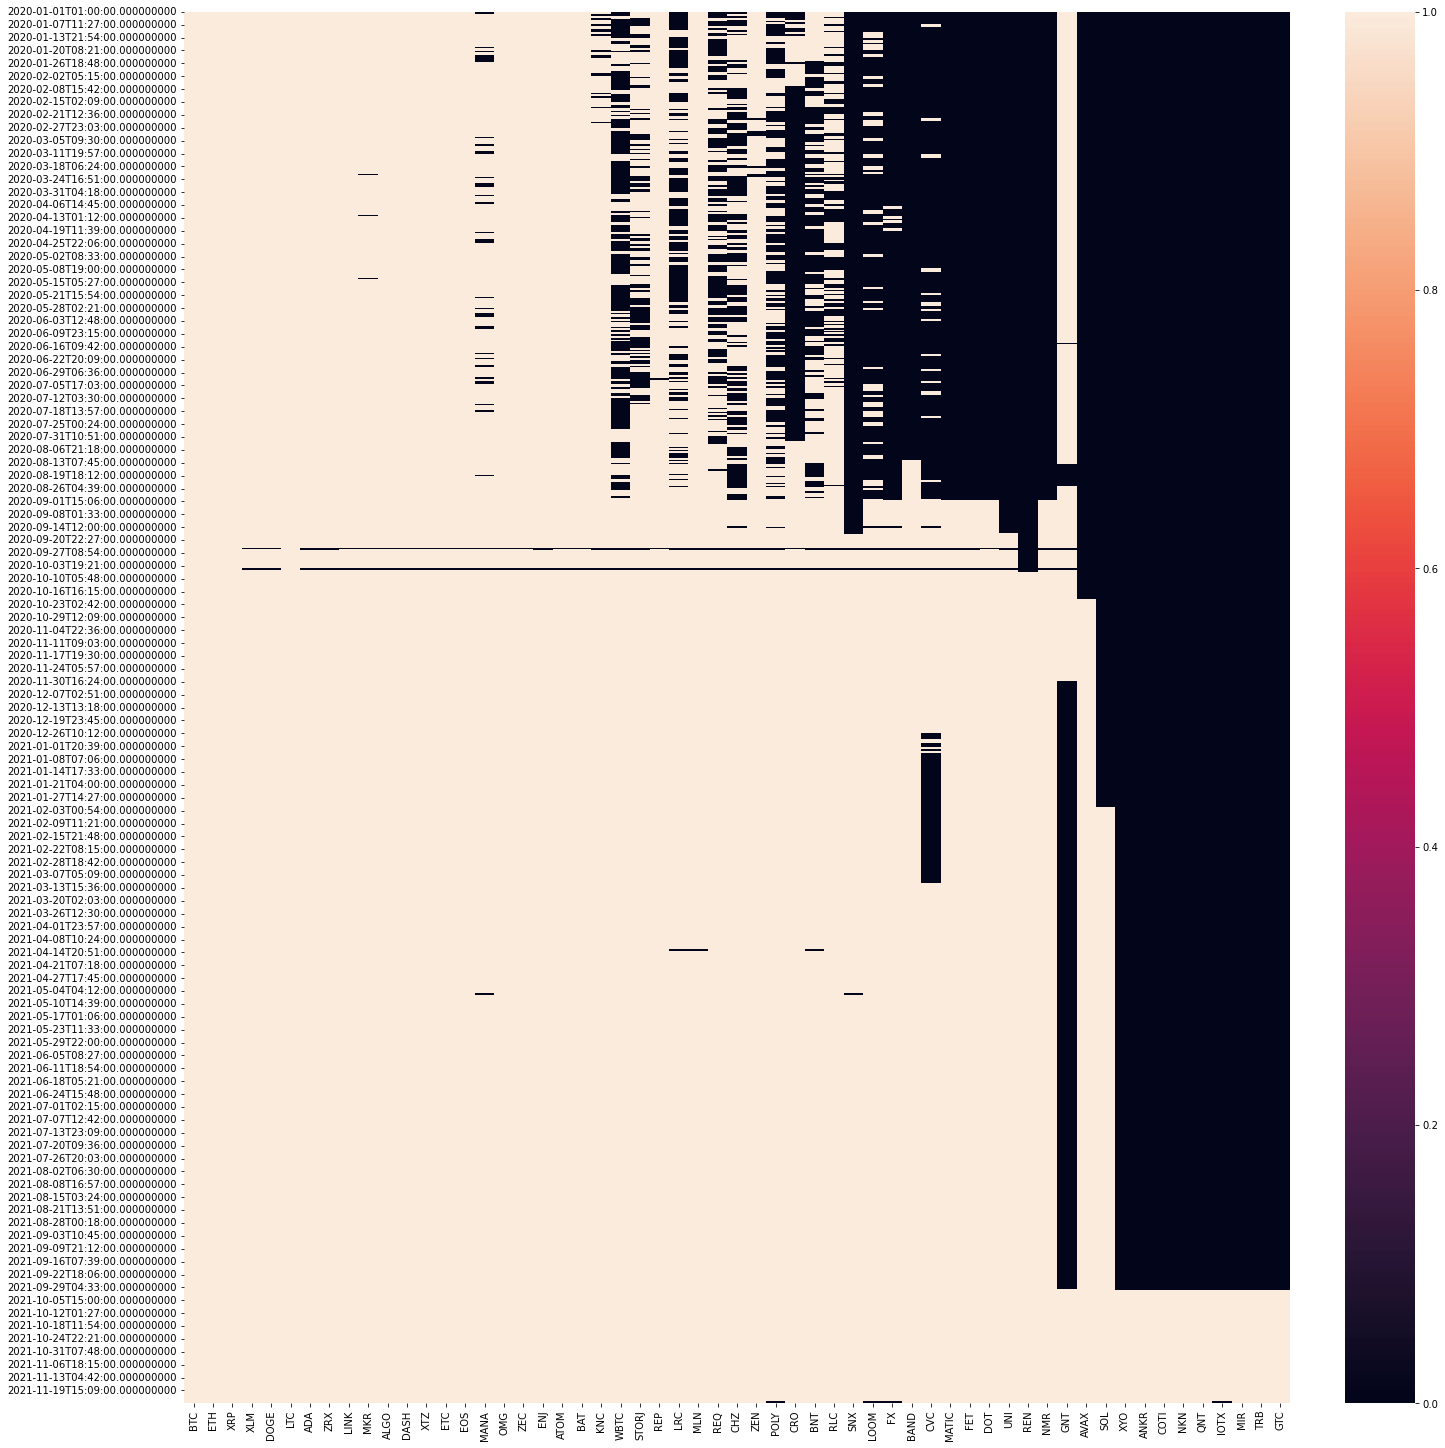

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20,20), constrained_layout=True)
ax = sns.heatmap(has_data)

<BarContainer object of 57 artists>

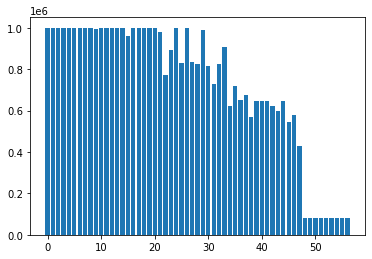

In [15]:
# compute number of data points per coin
plt.bar(np.arange(len(has_data.columns)), has_data.sum(axis=0))

# compute correlation matrices based on specified history h (h = 1 hour, 1 day, 1 week?)

I slice the data frame into a matrix containing data between two time points (e.g. for h = hour (technically 59 minutes): 00:00 to 00:59) to compute the correlation matrix from. The next time slot would be 01:00 to 01:59.
or slice them like 00:01 to 01:00? The latter was implemented.

In [16]:
print(f"the first time stamp in the data set is: {log_returns_df.index[0]}")
print(f"the last time stamp in the data set is: {log_returns_df.index[-1]}")

the first time stamp in the data set is: 2020-01-01 01:00:00
the last time stamp in the data set is: 2021-11-26 00:59:00


The code below raises some warnings as some slices contain NaN values. They just result in NaN values in the correlation matrices. The names of the correlation matrix files are the full timestamps.

In [17]:
# iterate over moving window of size h to get distinct matrices to compute the correlation on
# start with h = 1 week
one_minute = datetime.timedelta(0,60,0)

# always -60 seconds to not include any data point twice. values:
# h_hour = (0, 59*60, 0)  # (days, seconds, microseconds)
# h_day = (1, -60, 0)
# h_week = (7, -60, 0)
h = datetime.timedelta(7, -60, 0)

# get timestamps at which to create a correlation matrix with the trailing h as data points. equally spaced (exact hour, day, month)
time_stamps = []
t = log_returns_df.index[0] 
while t < log_returns_df.index[-1]:
    time_stamps.append(t)
    t += h + one_minute

for t in time_stamps:
    if t+h < time_stamps[-1]:
        interval_start = t + one_minute
        interval_end = interval_start + h
        # slice dataframe as discussed above
        data_slice = log_returns_df.loc[interval_start:interval_end, ]
        corr = np.corrcoef(data_slice.values.T)
        np.savetxt(f"data/corr_matrices/{interval_end}.csv", corr, delimiter=",")

        # compute and save dimensions of the data from which the correlation matrix comes
        N, T = data_slice.values.shape

    else: # ignore last data points if they don't fill a full slice (equally long time interval)
        print(f"last used timestamp: {t}")

# save dimensions from data
np.savetxt("data/data_slice_dim_(N,T).txt", np.array([N, T]))

/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/num

last used timestamp: 2021-11-24 01:00:00


/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/num

In [18]:
# save tickers as a txt file with one ticker per row
tickers_string = ""
for i in tickers: tickers_string += f"{i}\n"
ticker_string = tickers_string[:-1]
with open("data/corr_matrix_tickers.txt", "w") as f:
    f.write(tickers_string)

## Look at all correlation matrices

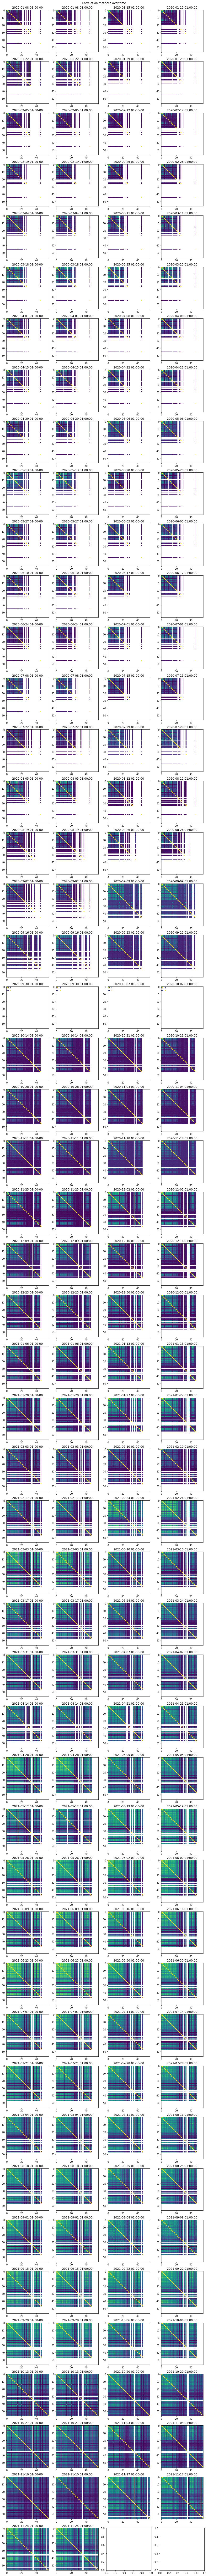

In [19]:
# load all correlation matrices and plot them
corrmats = load_all_corrmats()
print_corrmats(corrmats)